# Single member analyses of models with future scenarios

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

datapath = '../Processed_data/Nino3_4_DJF/'
experiments = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'MIROC-ES2L', 
          'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM', 'MCM-UA-1-0']

# create dictionary of data for each model, containing only the member we want to use:
data_dict = {}
for model in models:
    data_dict[model] = {}
    
    file = datapath + model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(file, index_col=0, header=[0,1], keep_default_na = False)
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM']:
        for exp in experiments:
            member = 'r1i1p1f1'
            data_list = data_table[exp][member].values
            data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1','MCM-UA-1-0', 'UKESM1-0-LL']:
        for exp in experiments:
            if exp == 'piControl' and model == 'MCM-UA-1-0':
                member = 'r1i1p1f1'
            else:
                member = 'r1i1p1f2' # I have checked that historical f2 branches from piControl f1 in MCM-UA-1-0.
            if exp in data_table: # additional if-test here, since 'MCM-UA-1-0' is missing the 'ssp126' experiment
                data_list = data_table[exp][member].values
                data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])         
    elif model in ['CNRM-ESM2-1']:
        for exp in experiments:
            if exp == 'piControl':
                member = 'r1i1p1f2'
            else: 
                member = 'r2i1p1f2' # I have checked that historical r2 branches from piControl r1.
            data_list = data_table[exp][member].values
            data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])  
# We know from testing in Figure 1 that all time series for these members are long enough (no missing years)

## Choose a model

In [2]:
model = models[-1]
model

'MCM-UA-1-0'

ssp245
ssp370
ssp585


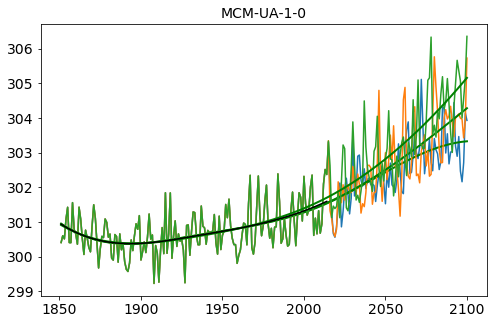

In [3]:
fig, ax = plt.subplots(figsize = [8,5])

internal_knots = [1850 + (2014-1850)/2, 2014] # = historical midpoint (1932) and endpoint (2014)

hist_years = np.arange(1851, 2015) # no DJF mean in 1850
ssp_years = np.arange(2015, 2101)
all_years = np.arange(1851, 2101)
ssp_length = 86; # cut in year 2100. Some exp go beyond this year.

hist_data = data_dict[model]['historical']
hist_trends = {}

# combine historical and ssp data, then smooth the combined time series
# to minimize discontinuity of the trend between years 2014 - 2015
for exp in data_dict[model].keys():
    if exp not in ['piControl', 'historical']:
        print(exp)
        exp_data = np.concatenate((hist_data, data_dict[model][exp][:ssp_length]))
        plt.plot(all_years, exp_data) 
        spl = LSQUnivariateSpline(all_years, exp_data, internal_knots)
        hist_trends[exp] = spl(hist_years)
        ax.plot(all_years, spl(all_years), 'g', lw=2)
    
# define historical trend as the mean trend over the historical period
hist_trends_mean = np.zeros_like(hist_years, dtype=float)
for t in range(len(hist_years)):
    hist_trends_mean[t] = np.mean([hist_trends[exp][t] for exp in hist_trends.keys()])

ax.plot(hist_years, hist_trends_mean, color = 'black');
ax.set_title(model, fontsize = 14)
ax.tick_params(axis='both',labelsize=14)   
#ax.set_xlim(1850, 2015)
#ax.set_ylim(299, 301)

## Loop through all models and create dictionary of anomaly data:

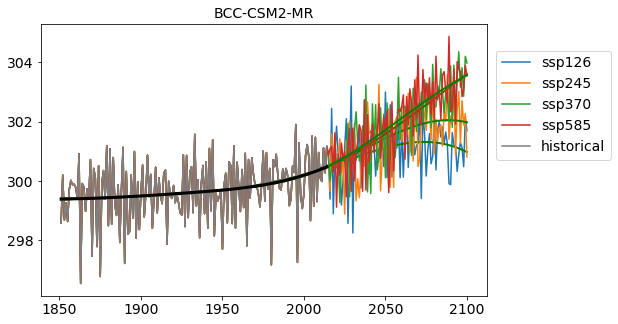

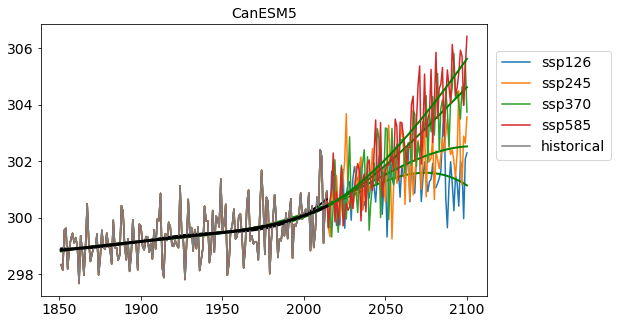

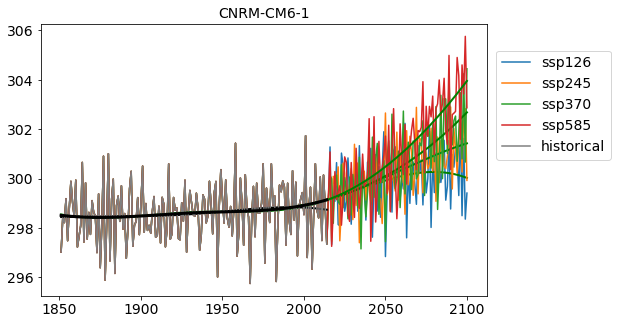

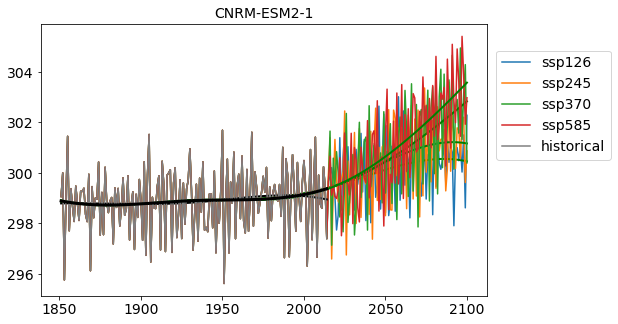

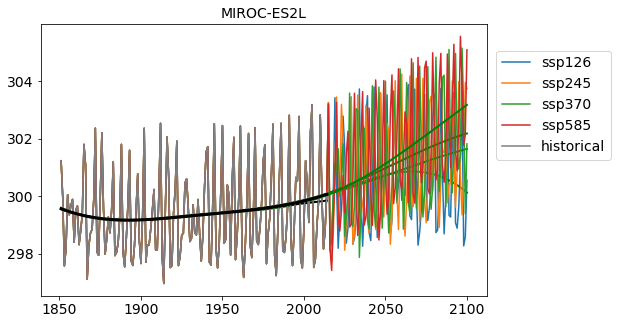

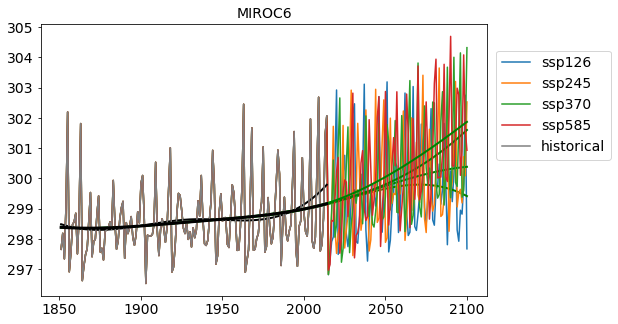

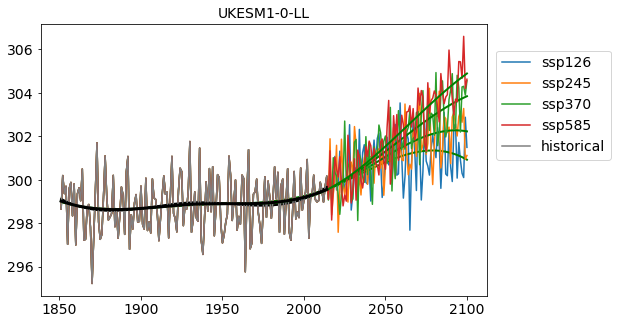

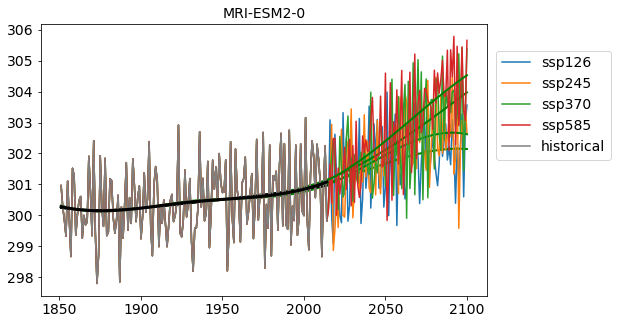

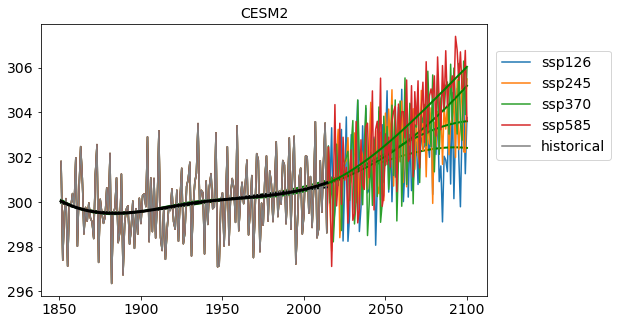

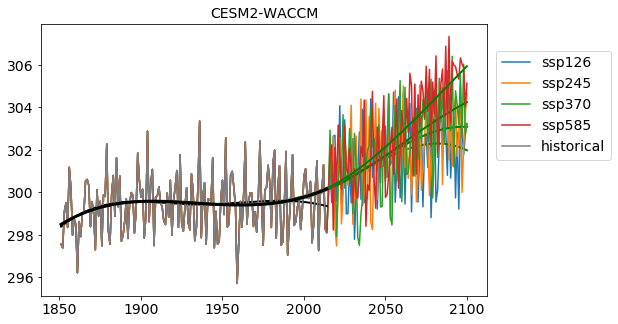

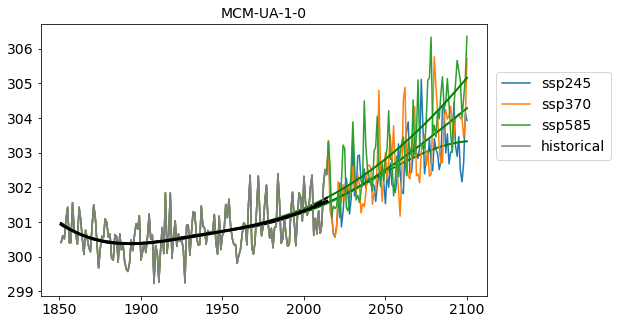

In [4]:
internal_knots = [1850 + (2014-1850)/2, 2014] # = historical midpoint (1932) and endpoint (2014)

hist_years = np.arange(1851, 2015) # no DJF mean in 1850
ssp_years = np.arange(2015, 2101)
all_years = np.arange(1851, 2101)
ssp_length = 86; # cut in year 2100. Some exp go beyond this year.

anomalies = {}

for model in models:
    anomalies[model] = {}
    fig, ax = plt.subplots(figsize = [8,5])

    hist_data = data_dict[model]['historical']
    hist_trends = {}

    # combine historical and ssp data, then smooth the combined time series
    # to minimize discontinuity of the trend between years 2014 - 2015
    for exp in data_dict[model].keys():
        if exp not in ['piControl', 'historical']:
            exp_data = np.concatenate((hist_data, data_dict[model][exp][:ssp_length]))
            plt.plot(all_years, exp_data, label = exp) 
            spl = LSQUnivariateSpline(all_years, exp_data, internal_knots)
            hist_trends[exp] = spl(hist_years)
            ax.plot(all_years, spl(all_years), 'g', lw=2)
            
            # save ssp anomaly in dictionary
            anomalies[model][exp] = data_dict[model][exp][:ssp_length] - spl(ssp_years)

    # define historical trend as the mean trend over the historical period
    hist_trends_mean = np.zeros_like(hist_years, dtype=float)
    for t in range(len(hist_years)):
        hist_trends_mean[t] = np.mean([hist_trends[exp][t] for exp in hist_trends.keys()])
    
    # compute also trend for historical separately, for comparison:
    spl = LSQUnivariateSpline(hist_years, hist_data, [internal_knots[0]])
    ax.plot(hist_years, spl(hist_years), 'black', lw=2)
    
    # save historical anomaly in dictionary
    anomalies[model]['historical'] = hist_data - hist_trends_mean
    
    ax.plot(hist_years, hist_data, color = 'gray', label = 'historical')
    ax.plot(hist_years, hist_trends_mean, color = 'black', lw=3);
    ax.set_title(model, fontsize = 14)
    ax.tick_params(axis='both',labelsize=14)
    ax.legend(loc=(1.02,0.5), fontsize = 14);
    

## Define anomalies in piControl as deviation from a linear trend fit for all years available

In [5]:
exp = 'piControl'
for model in models:
    control_data = data_dict[model][exp]
    p = np.polyfit(np.arange(len(control_data)), control_data, deg = 1)
    trend = np.polyval(p,np.arange(len(control_data)))
    anomalies[model][exp] = control_data - trend


In [6]:
# convert to dataframe before saving:
df = None
for model in models:
    for exp in experiments:
        if exp in anomalies[model]:
            colname = [(model, exp)]
            df_col = pd.DataFrame(anomalies[model][exp], columns = colname)
            if df is None:
                df = df_col
            else:
                df = pd.merge(df, df_col, left_index=True, right_index=True, how='outer')
df.columns = pd.MultiIndex.from_tuples(df.columns, names=['Model', 'Experiment'])
#df.to_csv('../Processed_data/Nino3_4_DJF/detrended_single_members.txt')
df

Model      BCC-CSM2-MR                                                     \
Experiment   piControl historical    ssp126    ssp245    ssp370    ssp585   
0             1.259065  -0.806082  0.461267  0.475842  0.309658  0.341288   
1             0.181101   0.807289 -1.109190 -0.861313 -0.528840  0.556495   
2            -0.406961  -0.705913  1.931947  1.046596 -0.077097  0.598862   
3             0.962368  -0.131567 -1.643999  0.066625 -0.181509 -0.287137   
4            -0.185085  -0.759733  0.381651 -0.052493  0.898776  1.007589   
...                ...        ...       ...       ...       ...       ...   
1194               NaN        NaN       NaN       NaN       NaN       NaN   
1195               NaN        NaN       NaN       NaN       NaN       NaN   
1196               NaN        NaN       NaN       NaN       NaN       NaN   
1197               NaN        NaN       NaN       NaN       NaN       NaN   
1198               NaN        NaN       NaN       NaN       NaN       NaN   

Model        CanESM5                                 ... CESM2-WACCM  \
Experiment piControl historical    ssp126    ssp245  ...  historical   
0          -0.169051  -0.512287 -0.763865 -0.858403  ...   -0.934859   
1           0.789181  -0.708638 -0.775173 -1.194731  ...   -1.151186   
2           0.268402   0.701893  1.181686  0.414227  ...    0.518438   
3           0.680252   0.758151  0.392706  0.105092  ...    0.874590   
4          -0.887917  -0.686667 -0.069756 -0.469528  ...   -0.320809   
...              ...        ...       ...       ...  ...         ...   
1194             NaN        NaN       NaN       NaN  ...         NaN   
1195             NaN        NaN       NaN       NaN  ...         NaN   
1196             NaN        NaN       NaN       NaN  ...         NaN   
1197             NaN        NaN       NaN       NaN  ...         NaN   
1198             NaN        NaN       NaN       NaN  ...         NaN   

Model                                              MCM-UA-1-0             \
Experiment    ssp126    ssp245    ssp370    ssp585  piControl historical   
0          -0.298716 -0.222123 -0.244576 -0.270042  -0.710839  -0.527641   
1           1.369793  1.938095  2.745405  1.368776  -0.448969  -0.302611   
2          -0.798059  0.183348 -0.195922  1.941705  -0.357765  -0.363573   
3           2.292251  2.341526  0.111900 -2.113054   0.714426   0.235135   
4           2.307275 -1.949754  1.390159  1.732355   0.376134   0.601960   
...              ...       ...       ...       ...        ...        ...   
1194             NaN       NaN       NaN       NaN        NaN        NaN   
1195             NaN       NaN       NaN       NaN        NaN        NaN   
1196             NaN       NaN       NaN       NaN        NaN        NaN   
1197             NaN       NaN       NaN       NaN        NaN        NaN   
1198             NaN       NaN       NaN       NaN        NaN        NaN   

Model                                     
Experiment    ssp245    ssp370    ssp585  
0           1.747949  1.774276  1.609223  
1           0.223202 -0.268454  0.875206  
2          -0.289724 -0.507140 -0.650271  
3          -0.955755 -0.917038 -0.342361  
4          -1.082332 -1.082984 -0.441335  
...              ...       ...       ...  
1194             NaN       NaN       NaN  
1195             NaN       NaN       NaN  
1196             NaN       NaN       NaN  
1197             NaN       NaN       NaN  
1198             NaN       NaN       NaN  

[1199 rows x 65 columns]

## Study anomalies:

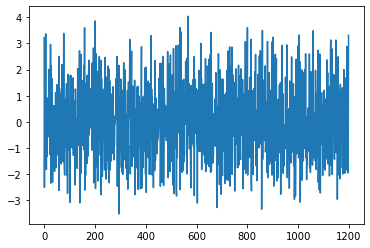

In [80]:
plt.plot(anomalies['CESM2']['piControl']);

# Compute variance for each model and experiment:

### Put results in a Figure similar to Figure 1 (Could be plot b) in Figure 1)

In [7]:
# define x-coordiates and colors for each experiment
x = {}
colors = ['black', 'blue', 'purple', 'red', 'green', 'cyan']
color_dict = {}
delta_x = 0.1
for ind,exp in enumerate(experiments):
    x[exp] = np.arange(len(models)) + 1 + delta_x*ind
    color_dict[exp] = colors[ind]

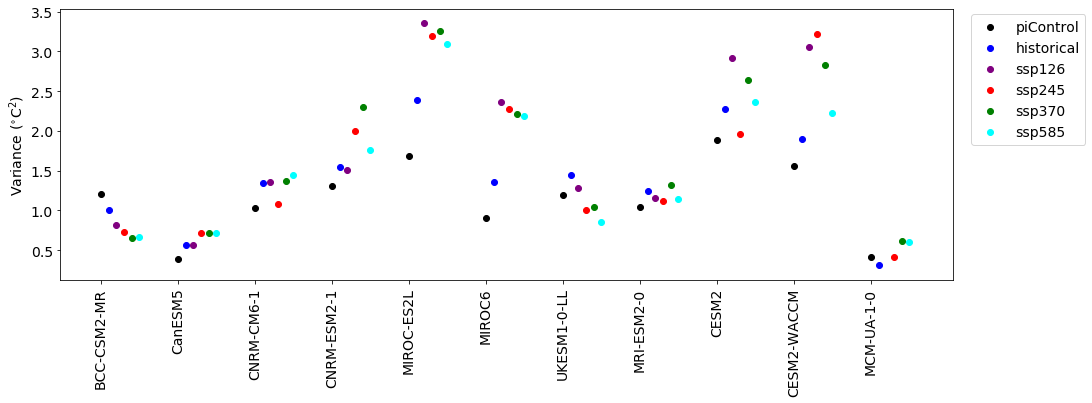

In [8]:
# create figure:
fig, ax = plt.subplots(figsize = [16,5])

for (k,model) in enumerate(models):
    for exp in experiments:
        if exp in anomalies[model]:
            anom = anomalies[model][exp]
            if k == 1:
                ax.scatter(x[exp][k], anom.var(),  marker = 'o', color=color_dict[exp], label = exp)
            else:
                ax.scatter(x[exp][k], anom.var(),  marker = 'o', color=color_dict[exp])
            
ax.tick_params(axis='both',labelsize=14)    
ax.set_ylabel('Variance ($^{\circ}$C$^2$)', fontsize = 14)
plt.xticks(x['piControl'], models, rotation=90);
ax.legend(loc=(1.02,0.5), fontsize = 14);


## Spectral analysis

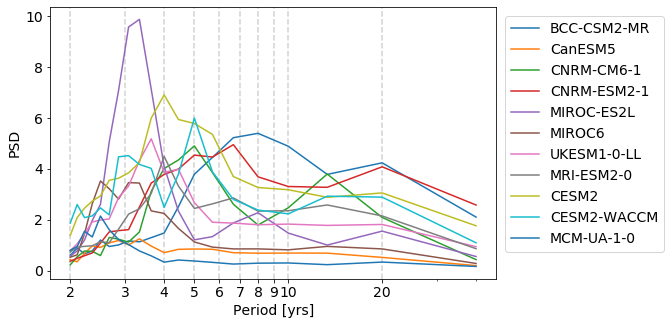

In [9]:
from scipy import signal

exp = 'piControl'
#exp = 'historical'

#x_axis = 'frequency'
x_axis = 'period'

fig, ax = plt.subplots(figsize = (8,5))

# plot vertical lines at given periods:
xcoords = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
for xc in xcoords:
    if x_axis == 'frequency':
        ax.axvline(x=1/xc, color='lightgray', linestyle='--')
    elif x_axis == 'period':
        ax.axvline(x=xc, color='lightgray', linestyle='--')
    
for model in models:
    x = anomalies[model][exp]
    f, Pxx_den = signal.welch(x, nperseg=40)
    if x_axis == 'frequency':
        #plt.loglog(f, Pxx_den, label = model)
        plt.semilogx(f, Pxx_den, label = model)
        #plt.xticks(1/np.array(xcoords),[str($\frac{1}{xcoords[i]}$) for i in range(len(xcoords))])
        plt.xticks(1/np.array(xcoords),['1/' +str(xcoords[i]) for i in range(len(xcoords))])
        plt.xlabel('frequency [yr$^{-1}$]', fontsize = 14)
    elif x_axis == 'period':
        plt.semilogx(1/f[1:], np.flip(Pxx_den[1:]), label = model)
        plt.xticks(np.array(xcoords),np.array(xcoords))
        plt.xlabel('Period [yrs]', fontsize = 14)
    

plt.ylabel('PSD', fontsize = 14)
ax.legend(loc=(1.02,0.1), fontsize = 14);
plt.tick_params(axis='both', labelsize = 14)

plt.show()


In [121]:
model = models[0]
model

'BCC-CSM2-MR'

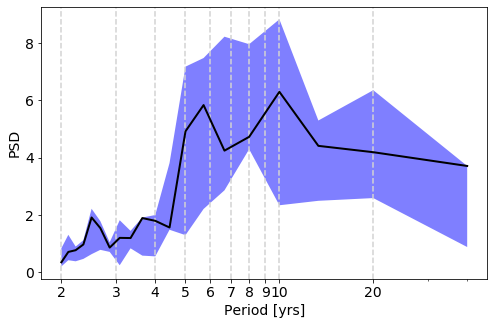

In [123]:
fig, ax = plt.subplots(figsize = (8,5))

exp = 'piControl'
seg_length = 165; nperseg = 40
overlap = seg_length - 30; 
x = anomalies[model][exp][:500]

# plot vertical lines at given periods:
xcoords = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
for xc in xcoords:
    ax.axvline(x=xc, color='lightgray', linestyle='--')

starttimes = np.arange(0,len(x)-seg_length+1,seg_length - overlap)
segment_list = np.full((len(starttimes), seg_length), np.nan)
Pxx_list = np.full((len(starttimes), int(nperseg/2)), np.nan)
for (i,k) in enumerate(starttimes):
    segment = x[k:k+seg_length]; segment_list[i] = segment
    #print(i, k, len(segment))
    f, Pxx = signal.welch(segment, nperseg=nperseg); Pxx_list[i] = Pxx[1:]
    #ax.semilogx(1/f[1:], np.flip(Pxx[1:]))
    #ax.plot(1/f[1:], np.flip(Pxx[1:]))
    
# find min and max values obtained at each frequency:
min_vals = np.zeros(int(nperseg/2)); max_vals = np.zeros(int(nperseg/2));
for (i,fi) in enumerate(f[1:]):
    Pxx_i = Pxx_list[:,i]
    min_vals[i] = Pxx_i.min()
    max_vals[i] = Pxx_i.max()
    
ax.fill_between(1/f[1:], np.flip(min_vals), np.flip(max_vals), facecolor='blue', alpha=0.5)   

exp = 'historical'
x = anomalies[model][exp]
f, Pxx = signal.welch(segment, nperseg=nperseg);
ax.semilogx(1/f[1:], np.flip(Pxx[1:]), color = "black", linewidth = 2)


plt.xticks(np.array(xcoords),np.array(xcoords))
plt.xlabel('Period [yrs]', fontsize = 14)

plt.ylabel('PSD', fontsize = 14)
#ax.legend(loc=(1.02,0.1), fontsize = 14);
plt.tick_params(axis='both', labelsize = 14)

plt.show()

## Loop through all models

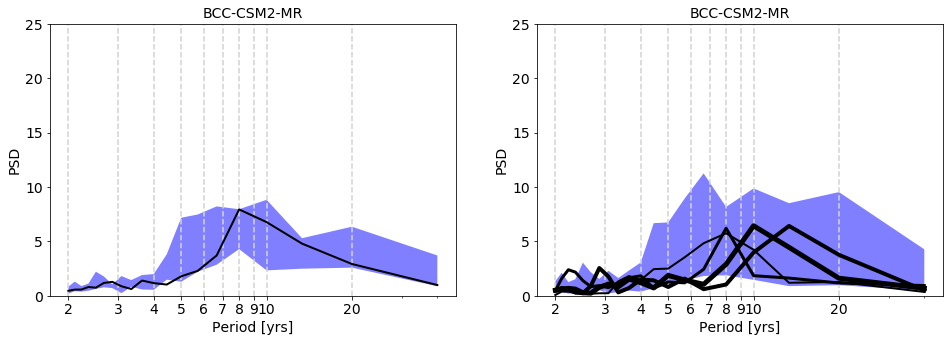

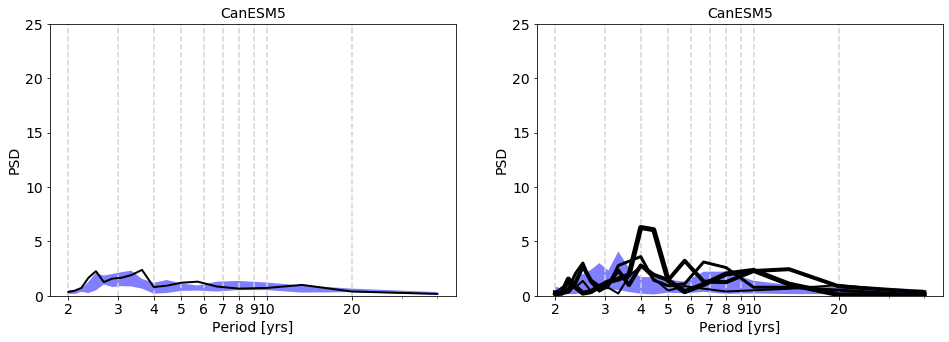

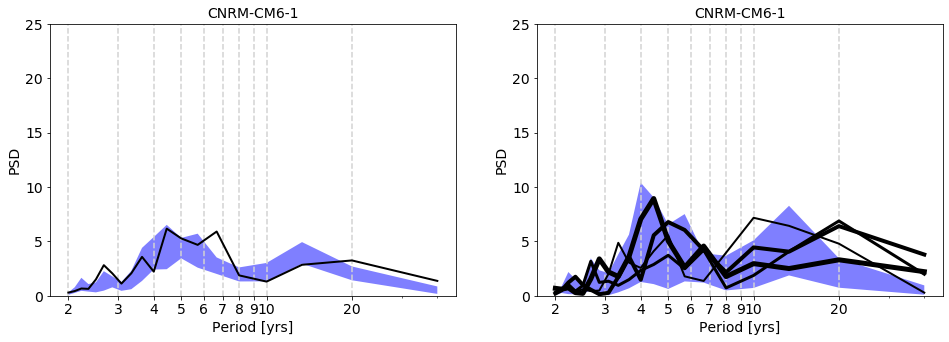

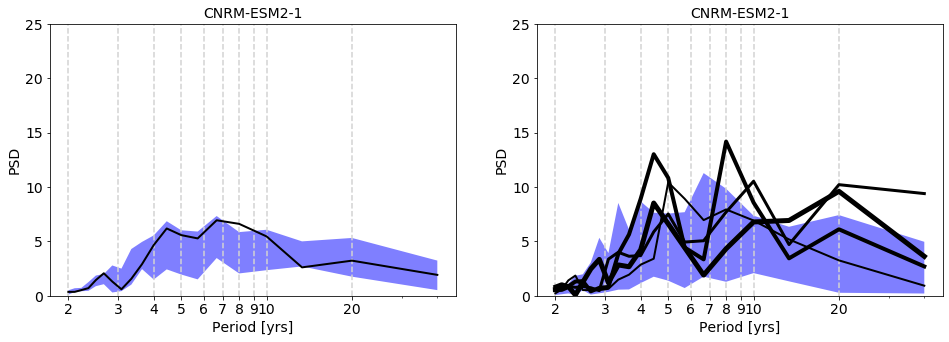

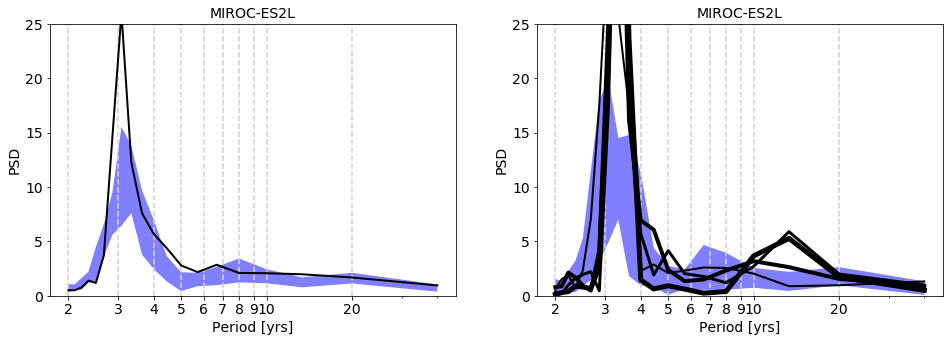

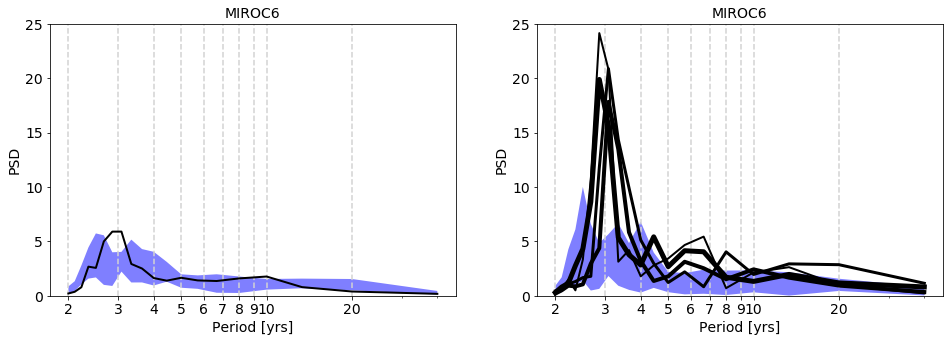

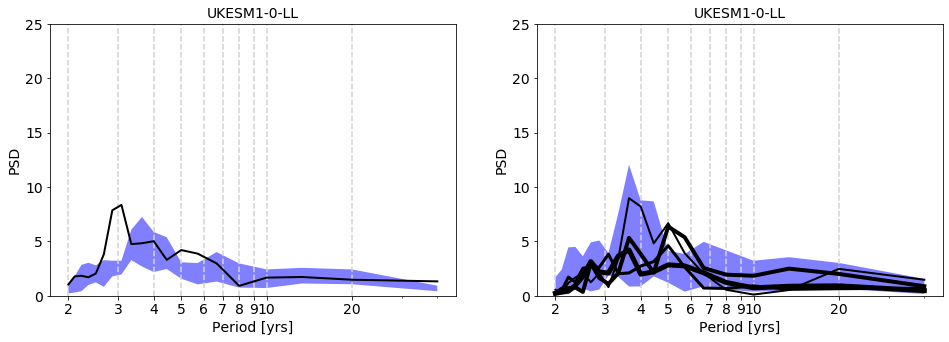

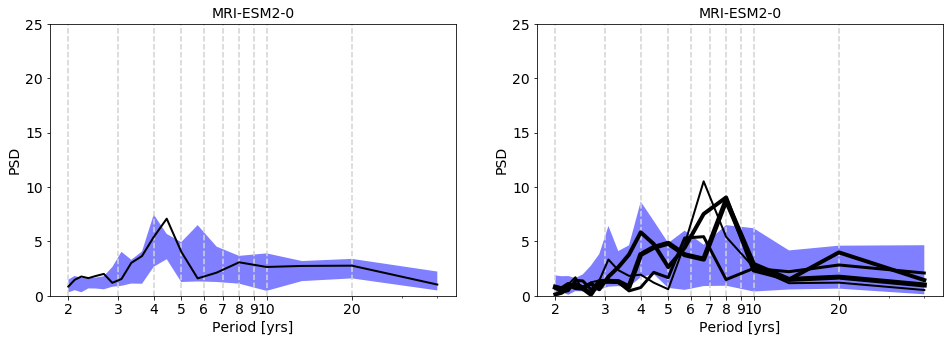

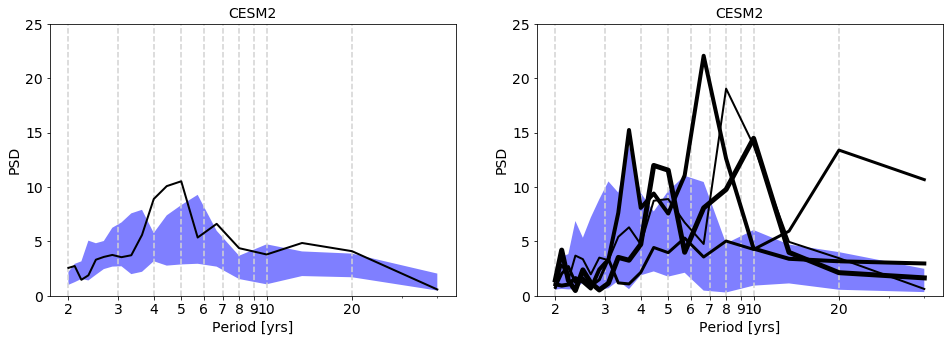

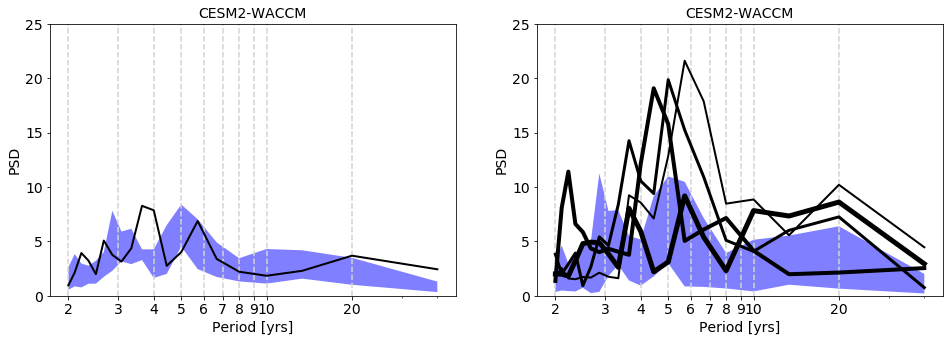

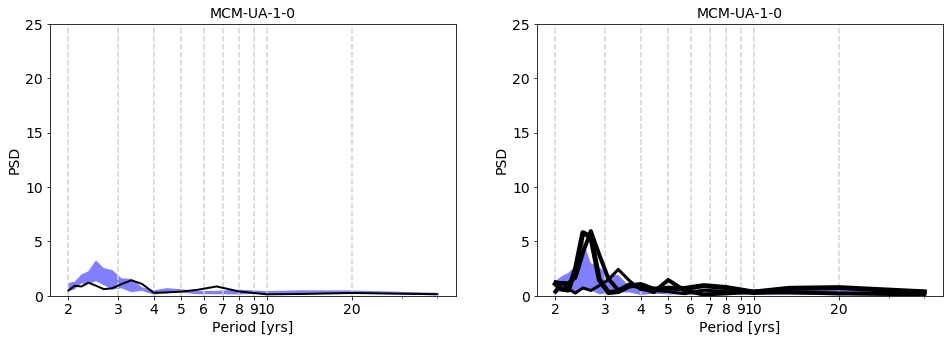

In [153]:
# plot vertical lines at given periods:
xcoords = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20]

for model in models:
    fig, ax = plt.subplots(ncols = 2, figsize = (8*2,5))
    exp = 'piControl'; 
    
    seg_length = 165; nperseg = 40
    overlap = seg_length - 30; 
    x = anomalies[model][exp][:500]
    for xc in xcoords:
        ax[0].axvline(x=xc, color='lightgray', linestyle='--')
        ax[1].axvline(x=xc, color='lightgray', linestyle='--')
    starttimes = np.arange(0,len(x)-seg_length+1,seg_length - overlap)
    segment_list = np.full((len(starttimes), seg_length), np.nan)
    Pxx_list = np.full((len(starttimes), int(nperseg/2)), np.nan)
    for (i,k) in enumerate(starttimes):
        segment = x[k:k+seg_length]; segment_list[i] = segment
        f, Pxx = signal.welch(segment, nperseg=nperseg); Pxx_list[i] = Pxx[1:]
    # find min and max values obtained at each frequency:
    min_vals = np.zeros(int(nperseg/2)); max_vals = np.zeros(int(nperseg/2));
    for (i,fi) in enumerate(f[1:]):
        Pxx_i = Pxx_list[:,i]
        min_vals[i] = Pxx_i.min()
        max_vals[i] = Pxx_i.max()
    ax[0].fill_between(1/f[1:], np.flip(min_vals), np.flip(max_vals), facecolor='blue', alpha=0.5)   

    exp = 'historical'
    x = anomalies[model][exp]
    f, Pxx = signal.welch(x, nperseg=nperseg);
    ax[0].semilogx(1/f[1:], np.flip(Pxx[1:]), color = "black", linewidth = 2)

    
    # plot for ssp
    exp = 'piControl'
    seg_length = 86; nperseg = 40
    overlap = seg_length - 30; 
    x = anomalies[model][exp][:500]
    starttimes = np.arange(0,len(x)-seg_length+1,seg_length - overlap)
    segment_list = np.full((len(starttimes), seg_length), np.nan)
    Pxx_list = np.full((len(starttimes), int(nperseg/2)), np.nan)
    for (i,k) in enumerate(starttimes):
        segment = x[k:k+seg_length]; segment_list[i] = segment
        f, Pxx = signal.welch(segment, nperseg=nperseg); Pxx_list[i] = Pxx[1:]
    # find min and max values obtained at each frequency:
    min_vals = np.zeros(int(nperseg/2)); max_vals = np.zeros(int(nperseg/2));
    for (i,fi) in enumerate(f[1:]):
        Pxx_i = Pxx_list[:,i]
        min_vals[i] = Pxx_i.min()
        max_vals[i] = Pxx_i.max()
    ax[1].fill_between(1/f[1:], np.flip(min_vals), np.flip(max_vals), facecolor='blue', alpha=0.5)  
    
    for (expind, exp) in enumerate(['ssp126', 'ssp245', 'ssp370', 'ssp585']):
        if exp in anomalies[model].keys():
            x = anomalies[model][exp][:seg_length]
            f, Pxx = signal.welch(x, nperseg=nperseg);
            ax[1].semilogx(1/f[1:], np.flip(Pxx[1:]), color = "black", linewidth = expind + 2)
    
    for axis in ax:
        axis.set_xticks(np.array(xcoords))
        axis.set_xticklabels(np.array(xcoords))
        axis.set_xlabel('Period [yrs]', fontsize = 14)
        axis.set_title(model, fontsize = 14)
        axis.set_ylabel('PSD', fontsize = 14)
        axis.tick_params(axis='both', labelsize = 14)
        axis.set_ylim(0, 25)
    plt.show()
    
    